# CNN: Inception Model Without Training, Save/ Restore
### Acknowledgement:  HandsOn Machine Learning with Scikit-Learn & Tensorflow

* by **Aurelien Geron**
* **O'Reilly Publishing**
* ISBN-13: **978-1491962299**
* **Excerpts from Chapter 2** – End-to-end Machine Learning project

Full code available on github:
https://github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb

Excerpts from Chapter 13 – CNN

**Note:** You may find differences between the code outputs in the book and in this Jupyter notebook: In addition to the differences acknowledged by the author, this notebook focuses on fetching and running the Inception 3 model **without** retraing the model.

# Objective:
* Learn how to use the Inception Model "off the shelf" 
* Learn simple way to save and restore the model 

# 1) Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [9]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [10]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [11]:
import tensorflow as tf

# Classifying large images using Inception v3

## 2) Download Images
Exercise: Download some images of various animals. Load them in Python, for example using the `matplotlib.image.mpimg.imread()` function or the `scipy.misc.imread()` function. Resize and/or crop them to 299 × 299 pixels, and ensure that they have just three channels (RGB), with no transparency channel. The images that the Inception model was trained on were preprocessed so that their values range from -1.0 to 1.0, so you must ensure that your images do too.

### All Images Scaled to 299x299x3

In [12]:
width = 299
height = 299
channels = 3

In [13]:
%%bash
cd images/cnn
ls

china_horizontal.png
china_max_pool.png
china_original.jpg
china_original.png
china_vertical.png
giraffe.jpg
giraffe.png
hyena.png
test_image.png


### Select and Display a Test Image

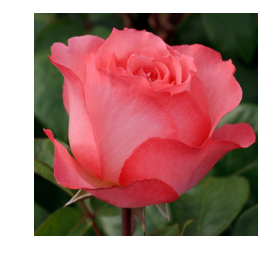

images/cnn/test_image.png


(299, 299, 3)

In [43]:
import matplotlib.image as mpimg
from PIL import Image

basewidth = 299
#img = Image.open(os.path.join("images","cnn","hyena.png"))
img = Image.open(os.path.join("rose-2.jpg"))
img = img.resize((basewidth,basewidth), Image.ANTIALIAS)
img.save(os.path.join("images","cnn","test_image.png") )


test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

print( os.path.join("images","cnn","test_image.png"))
test_image.shape

Ensure that the values are in the range [-1, 1] (as expected by the pretrained Inception model), instead of [0, 1]:

##  Transform the Test Image to Match the Model's Input Spec

In [44]:
test_image = 2 * test_image - 1

## 2) Download the Inception V3 Model
Download the latest pretrained Inception v3 model: the checkpoint is available at https://goo.gl/nxSQvl. The list of class names is available at https://goo.gl/brXRtZ, but you must insert a "background" class at the beginning.


**Define the functions** needed to download the Inception model

In [99]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

**Download the Inception 3 model**

In [100]:
fetch_pretrained_inception_v3()

In [101]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

Display some of the class names the model was originally trained with

In [102]:
class_names = ["background"] + load_class_names()
class_names[:5]

[u'background',
 u'tench, Tinca tinca',
 u'goldfish, Carassius auratus',
 u'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 u'tiger shark, Galeocerdo cuvieri']

#### Get a Feel for the Kinds of Classes in the Model

In [110]:
searchfor = 'rose'
print ("\n".join(s for s in class_names if searchfor.lower() in s.lower()) )
searchfor = 'tulip'
print ("\n".join(s for s in class_names if searchfor.lower() in s.lower()) )
searchfor = 'dog'
print ("\n".join(s for s in class_names if searchfor.lower() in s.lower()) )

hip, rose hip, rosehip

Maltese dog, Maltese terrier, Maltese
Tibetan terrier, chrysanthemum dog
Old English sheepdog, bobtail
Shetland sheepdog, Shetland sheep dog, Shetland
German shepherd, German shepherd dog, German police dog, alsatian
Greater Swiss Mountain dog
Bernese mountain dog
French bulldog
Eskimo dog, husky
dalmatian, coach dog, carriage dog
affenpinscher, monkey pinscher, monkey dog
pug, pug-dog
Newfoundland, Newfoundland dog
African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus
dogsled, dog sled, dog sleigh
hotdog, hot dog, red hot


In [111]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

310

The default test_image for this lab, is a rose and yet the inception model here predicts a bee!
The model will do much better at the hyena and other test_images

In another lab we will explore further how to retrain the model using **transfer learning** to make flower classification a speciality!

In [112]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

bee: 32.71%
picket fence, paling: 23.24%
pot, flowerpot: 6.56%
greenhouse, nursery, glasshouse: 5.18%
rapeseed: 4.05%


## 3) How to Save the Model
The next **couple of cells have been split apart unecessarily**, just to demonstrate that the model parameters can be saved and restored towards the ultimate goal of transfer learning.

TF-Slim is a lightweight library for defining, training and evaluating complex models in TensorFlow. Components of tf-slim can be freely mixed with native tensorflow, as well as other frameworks, such as tf.contrib.learn.

To run a given model on the train set (is_training=True)  
To run a given model on the vlidation set (is_training=False) 

Create the Inception v3 model by calling the `inception_v3()` function, as shown below. This must be done within an argument scope created by the `inception_v3_arg_scope()` function. Also, you must set `is_training=False` and `num_classes=1001` [...]

In [107]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim
# reset the defualt graph
reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()
predictions.shape
# end_points gives info about the layers available, which will help us freeze the layers to this point

TensorShape([Dimension(None), Dimension(1001)])

In [108]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

310

## 4) Evaluate After Model is Restored
Run the model to classify the images you prepared. Display the top five predictions for each image, along with the estimated probability (the list of class names is available at https://goo.gl/brXRtZ). How accurate is the model?


test_image.shape

In [94]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


Display the most likely index that the test_image predicts

In [95]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

310

Display the name of the predicted class

In [96]:
class_names[most_likely_class_index]

u'bee'

Display the top 5 classes & probabilities 

In [105]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

bee: 32.71%
picket fence, paling: 23.24%
pot, flowerpot: 6.56%
greenhouse, nursery, glasshouse: 5.18%
rapeseed: 4.05%


The model is quite **accurate** on on many images such as **hyena**: if makes the right prediction with high confidence. *Unfortunately*, the model never trained on **giraffes** or **roses** !

In a different lab, we demonstrate how to do transfer learning to springboard off this model, tweak it with new data, so it will be able to classify roses, daisies, tulips and other flowers.